# TP1: Dynamic Programming and Reinforcement Learning

## Table of content
1. [Dynamic programming](#Dynamic-programming)
2. [Reinforcement learning](#Reinforcement-learning)


## Dynamic programming

### Q1 and Q2: 
- Implement the discrete MDP model.
- Implement and run value iteration in order to identify a 0.01–optimal policy. Recall that the stopping criterion (theory slides) is to stop when:
$$||v^{k+1} - v^{k}||_{\infty} < \epsilon $$
    which implies that:
$$||v^{\pi_{k+1}} - v^{*}|| < \frac{2 \epsilon\gamma}{1-\gamma} $$
    Where $\pi_{k+1}$ is the greedy policy w.r.t $v^{k+1}$

From the last expressions we find the stopping criterion $\epsilon$:
$$\epsilon = \frac{0.01 (1-\gamma)}{2\gamma}$$

Let's first compute the model variables, the probability matrix, the set of actions and states, and the reward matrix, and the parameters $\gamma$ and the precision $0.01$ and the initial value `v_0`.

In [1]:
import numpy as np
from ex1 import MDPModel
from ex2 import plot

In [2]:
set_actions = [0, 1]
set_states = [0, 1, 2]
gamma = 0.95
precision = 0.01
proba_matrix = np.array(
    [
        [[0.45, 0.],
        [0., 0.5],
        [0.6, 0.]]
        ,
        
        [[0., 0.],
        [0., 0.4],
        [0., 0.9]]
        ,
        
        [[0.55, 1.],
        [1., 0.1],
        [0.4, 0.1]]
        
    ]
)
rewards = np.array(
    [[-0.4, 0.],
     [2., 0.],
     [-1., -0.5]]
)
v_0 = np.array([0, 0, 0])

Now we can create the MDP model

In [3]:
mdp_model = MDPModel(proba_matrix, rewards, gamma, set_actions, set_states, precision, max_iter=10000)

In [4]:
mdp_model.run_value_iteration(v_0)

Iteration number: 0
Iteration number: 10
Iteration number: 20
Iteration number: 30
Iteration number: 40
Iteration number: 50
Iteration number: 60
Iteration number: 70
Iteration number: 80
Iteration number: 90
Iteration number: 100
Iteration number: 110
Iteration number: 120
Iteration number: 130
Iteration number: 140
Iteration number: 150
last iteration: 154


Let's look at the graph of $||v^{k} - v^{*}||_{\infty}$ for every iteration step $k$: To do that we first need to compute $v^*$ knowing that $\pi^* = [1, 0, 1]$.

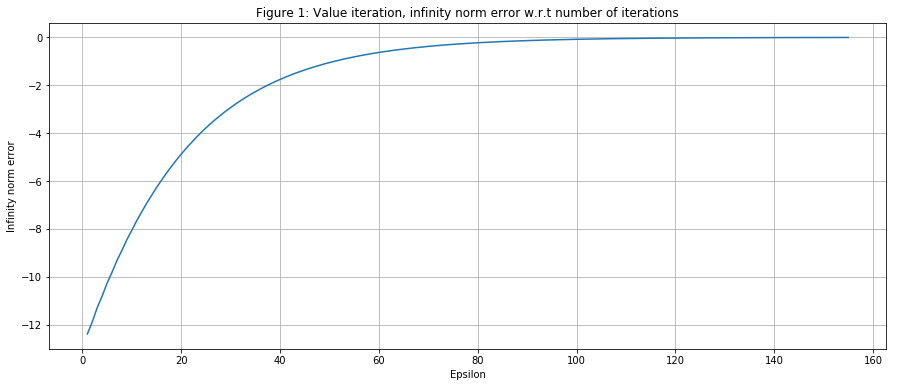

The infinity norm error is -0.0048236808 with an absolute value < 0.01


In [5]:
policy_opt = np.array([1,0,1])
v_opt_exact = mdp_model.policy_evaluation(policy_opt)
plot(range(1, mdp_model.last_iteration + 2), 
     np.array([v_opt - v_opt_exact for v_opt in mdp_model.v_values]).max(axis=1), 
     title="Figure 1: Value iteration, infinity norm error w.r.t number of iterations",
     xlabel="Epsilon", ylabel="Infinity norm error", num_fig=1)
print "The infinity norm error is %.10f with an absolute value < 0.01" % max(mdp_model.v_opt - v_opt_exact)

The learned policy is indeed the optimal one:

In [6]:
print "the learned policy is %s" % mdp_model.policy_opt

the learned policy is [ 1.  0.  1.]


### Q3: 
- implement policy iteration with arbitrary initial policy. Compare the speed of convergence w.r.t. Q2. and discuss the relative merits of the two approaches.

Let's run the policy iteration with a random initial policy.

In [7]:
policy_0 = np.random.randint(mdp_model.n_actions, size=mdp_model.n_states)
mdp_model.run_policy_iteration(policy_0)
print "the infinity norm error is %.5f" % max(mdp_model.v_opt - v_opt_exact)

Iteration number: 0
Iteration number: 1
Iteration number: 2
the infinity norm error is 0.00000


Remark: In this case the error is really $0$ because we computed the exact value function in the policy evaluation. Indeed we use the complete computation:
$$V^\pi =(I - \gamma P^\pi)^{-1} r^\pi$$

Since the number of states is small in our case, this operation is really fast. But this can be tricky for high dimension problems and we would actually use another policy evaluation method.

The pros and cons of the two approaches are:
- For the value iteration: one iteration is fast to compute. Applying the bellman operator is 1 computation per state. However The convergence is asymptotic.
- For the policy iteration: It converges in a finite number of iterations, and here it converges quite fast. But for high dimension problems, each iteration does a policy evaluation and that can be very costly in terms of performance 

## Reinforcement learning

### Q.4: 
1. Estimate the value function using first-visit Monte-Carlo, using the deterministic policy that is selecting the action right when available, otherwise up (the optimal policy). The estimated value function is:
$$Q_n(x,a) = \frac{1}{N(x,a)}\sum\limits_{k=1}^{N(x,a)}\;[\sum\limits_{t=1}^{Tmax}{\gamma^{t-1}r_t^{(k)}}]$$
2. Build such estimator and plot $J(n)$ and $J^\pi$ as a function of n, defined as follow, where $\mu_0$ is the uniform distribution in $\mathcal{X}$:
$$J(n) = \sum\limits_{x \in \mathcal{X}}{\mu_0(x)V_n(x)}$$
$$J^\pi = \sum\limits_{x \in \mathcal{X}}{\mu_0(x)V^\pi(x)}$$


In [8]:
import sys 
import numpy as np
import matplotlib.pyplot as plt
import random

from gridworld import GridWorld1
import gridrender as gui
import ex2

In [9]:
# Some useful constants
NB_POSSIBLE_ACTIONS = 4
T_MAX = 15

Let's initialize the environment model

In [10]:
env = GridWorld1

We are also given the variable $V^\pi$ noted `v_q4` in the code

In [11]:
v_q4 = np.array([0.87691855, 0.92820033, 0.98817903, 0.00000000, 0.67106071, -0.99447514, 
                 0.00000000, -0.82847001, -0.87691855, -0.93358351, -0.99447514])

We need to first compute some useful variables to run our algorithm

In [12]:
# Let's compute the optimal policy: going right, and if not possible going up.
p_opt = [0 if 0 in state_action else 3 for state_action in env.state_actions]
# Uncomment to see the policy on the grid, this will open a new window
# gui.render_policy(env, p_opt)

# We also need to compute the exact J value to compare it with J(n)
j_exact = v_q4.T.dot(np.ones(v_q4.shape[0]) * 1. / env.n_states)

Now we run the Monte-Carlo estimation together with the Agent/Environment Interaction algorithm

In [13]:
# We compute the Monte-Carlo Estimates and J(n) estimates for every iteration n
nb_iter=1000
q_estimate, j_estimate_values = ex2.get_monte_carlo_q_and_j_estimates(env, p_opt, nb_iter=nb_iter, t_max=T_MAX)

iteration number: 99
iteration number: 199
iteration number: 299
iteration number: 399
iteration number: 499
iteration number: 599
iteration number: 699
iteration number: 799
iteration number: 899
iteration number: 999


In [14]:
# Uncomment in order to see the Value function matrix on the grid
# q_list = matrix_to_array(q_estimate, env)
# gui.render_q(env, q_list)

Now we plot the difference between the exact value of $J^\pi$ and $J(n)$ at each iteration $n$ and we can see that it converges to 0. We actually compute the relative difference:
$$\Delta = \frac{J(n) - J^\pi}{J^\pi}$$

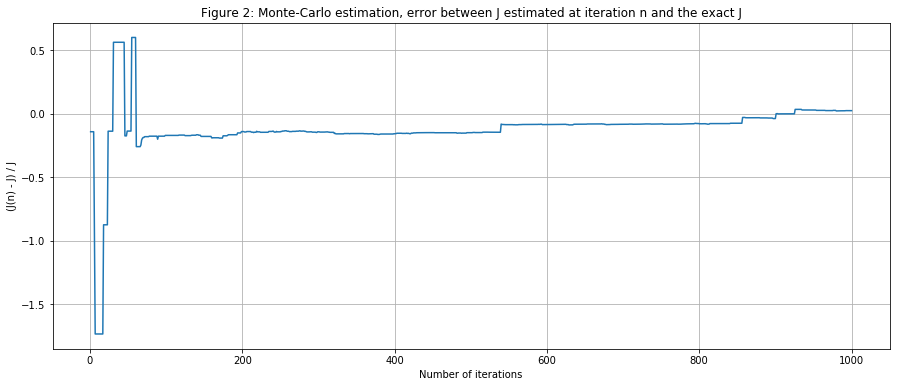

In [15]:
ex2.plot(range(1, nb_iter + 1), (np.array(j_estimate_values) - j_exact) / j_exact,
           title="Figure 2: Monte-Carlo estimation, error between J estimated at iteration n and the exact J", xlabel="Number of iterations",
           ylabel="(J(n) - J) / J", num_fig=2)

### Q.5:
1. You will implement Q-Learning in episodes of length $Tmax$, with an $\epsilon$-greedy exploration policy within each episode, i.e., select an action as $a_t = argmax Q(x_t, a)$ with probability $1 - \epsilon$ and randomize with probability $\epsilon$.
2. Describe the (parameters of the)  exploration policy and learning rate chosen, and illustrate the convergence of Q-Learning using some of the following performance metrics:
    - Performance over all the other state $||v^* - v^{\pi_n}||_{\infty}$, where $\pi_n$ is the greedy policy w.r.t. $Q_n$ at the end of the $n$-th episode
    - Reward cumulated over the episode
    
We will need here the optimal policy $V^*$ noted `v_opt` in the code:

In [16]:
v_opt = [0.87691855, 0.92820033, 0.98817903, 0.00000000, 0.82369294, 
         0.92820033, 0.00000000, 0.77818504, 0.82369294, 0.87691855, 0.82847001]

Let's first look at the effect of epsilon on the convergence. We will choose a learning rate of $\frac{1}{N(x_t,a_t)}$, which seems a good choice. And we will compare the performance according to the metrics explained above.

In [17]:
epsilon_values = np.arange(0., 1., 0.1)
# Those variables will store the infinity norm error
# between the optimal value function and the estimated value function
# and also the cumulated reward at each episode
infinity_norm_errors_per_epsilon = []
cumulated_rewards_per_epsilon = []

# We loop over epsilon and we compute the
for epsilon in epsilon_values:
    print "\nEpsilon value: %.2f\n" % epsilon
    infinity_norm_errors, cumulated_rewards, p = ex2.q_learning(env, nb_iter, T_MAX, epsilon, v_opt)
    infinity_norm_errors_per_epsilon.append(infinity_norm_errors[-1])
    cumulated_rewards_per_epsilon.append(cumulated_rewards[-1])


Epsilon value: 0.00

iteration number: 0
iteration number: 100
iteration number: 200
iteration number: 300
iteration number: 400
iteration number: 500
iteration number: 600
iteration number: 700
iteration number: 800
iteration number: 900

Epsilon value: 0.10

iteration number: 0
iteration number: 100
iteration number: 200
iteration number: 300
iteration number: 400
iteration number: 500
iteration number: 600
iteration number: 700
iteration number: 800
iteration number: 900

Epsilon value: 0.20

iteration number: 0
iteration number: 100
iteration number: 200
iteration number: 300
iteration number: 400
iteration number: 500
iteration number: 600
iteration number: 700
iteration number: 800
iteration number: 900

Epsilon value: 0.30

iteration number: 0
iteration number: 100
iteration number: 200
iteration number: 300
iteration number: 400
iteration number: 500
iteration number: 600
iteration number: 700
iteration number: 800
iteration number: 900

Epsilon value: 0.40

iteration number: 

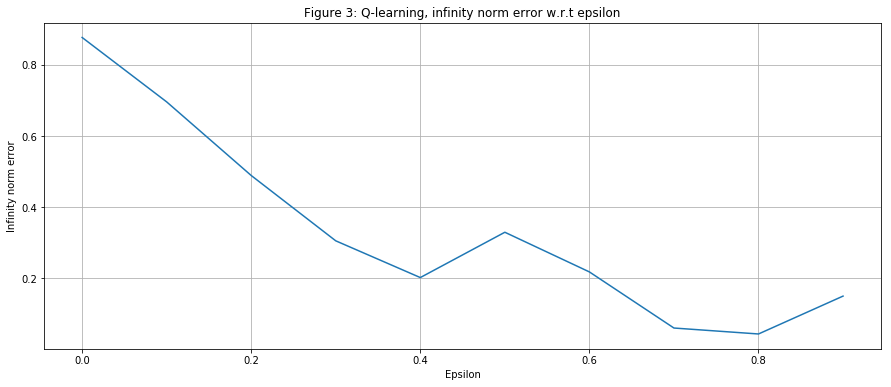

In [18]:
plot(epsilon_values, infinity_norm_errors_per_epsilon, title="Figure 3: Q-learning, infinity norm error w.r.t epsilon",
     xlabel="Epsilon", ylabel="Infinity norm error", num_fig=3)

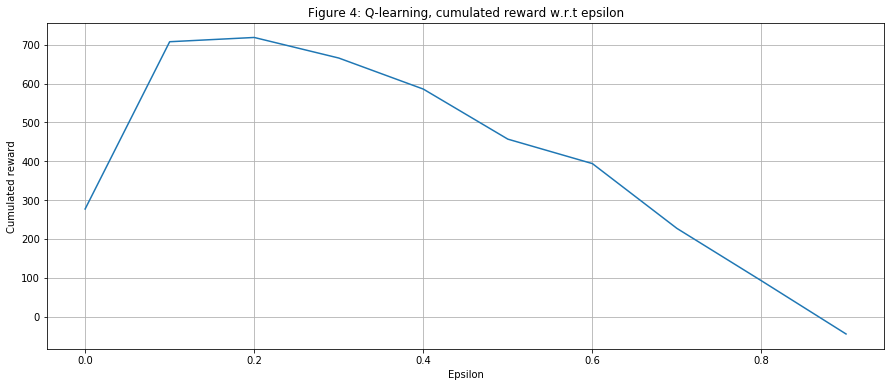

In [19]:
plot(epsilon_values, cumulated_rewards_per_epsilon, title="Figure 4: Q-learning, cumulated reward w.r.t epsilon",
     xlabel="Epsilon", ylabel="Cumulated reward", num_fig=4)

According to Figure 2 and 3, a good trade-off between the infinity norm error and the cumulated reward is an $\epsilon$ between $0.2$ and $0.3$. Let's choose:

$$\epsilon = 0.2$$

Let's see how the Q-learning algorithm converges w.r.t the number of iterations.

iteration number: 0
iteration number: 10000
iteration number: 20000
iteration number: 30000
iteration number: 40000
iteration number: 50000
iteration number: 60000
iteration number: 70000
iteration number: 80000
iteration number: 90000


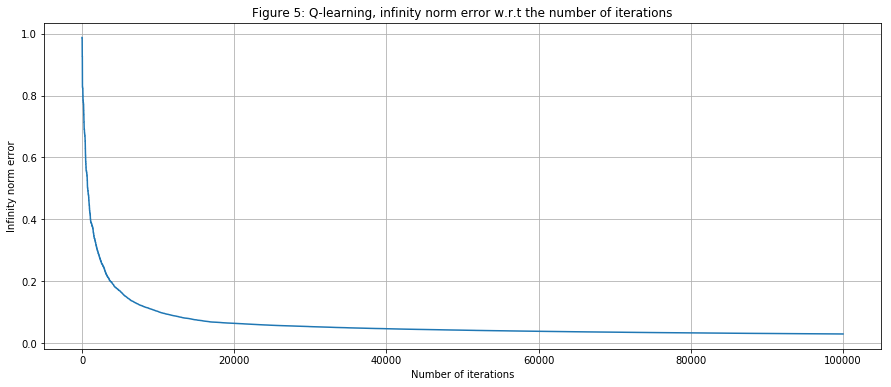

In [20]:
epsilon = 0.2
nb_iter = 100000
infinity_norm_errors, cumulated_rewards, p = ex2.q_learning(env, nb_iter, T_MAX, epsilon, v_opt)
plot(range(1, nb_iter + 1), infinity_norm_errors, title="Figure 5: Q-learning, infinity norm error w.r.t the number of iterations",
     xlabel="Number of iterations", ylabel="Infinity norm error", num_fig=5)

As we were expecting, the error tends to $0$, however the convergence is quite slow 

### Q6: 
- Is the optimal policy of an MDP affected by the change of the initial distribution μ0?

The theoretical optimal policy of an MDP is not affected by the initial distribution. Indeed the initial distribution describes how  we explore the set of states. If the initial distribution has a high density on "bad" states that lead to a low reward, and a low density on the high "good" states with high reward, we might get stuck in a local minimum. 